In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

# BLACK WITH FATHER

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'BL_woF'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [3]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [4]:
def load_subject(subject):
    df_mouse = pd.read_csv(data_directory + subject + '/cells_700.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

In [9]:
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_BL_woF_17_31.npy', 
                                   allow_pickle=True).item()

In [17]:
subjects_32_44 = [sub for sub in subjects if sub not in list(dict_results_across_mice.keys())]

In [18]:
# # NB: Run only if file does not exist or needs to be regenerated
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects_32_44}
np.save('dict_results/dict_results_across_mice_BL_woF_32_44.npy', dict_results_across_mice)

/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/pytho

In [20]:
# merge the two dictionaries
dict_results_across_mice.update(np.load('dict_results/dict_results_across_mice_BL_woF_17_31.npy', 
                                   allow_pickle=True).item())

In [23]:
np.save('dict_results/dict_results_across_mice_BL_woF.npy', dict_results_across_mice)


In [24]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)


In [25]:
experimental_groups

{'Control': ['BL17Control',
  'BL26Control',
  'BL23Control',
  'BL44Control',
  'BL41Control',
  'BL29Control',
  'BL20Control',
  'BL32Control'],
 'Unfam': ['BL35Unfam',
  'BL22Unfam',
  'BL39Unfam',
  'BL25Unfam',
  'BL38Unfam',
  'BL31Unfam',
  'BL28Unfam',
  'BL33Unfam',
  'BL19Unfam'],
 'Fam': ['BL43Fam',
  'BL42Fam',
  'BL24Fam',
  'BL34Fam',
  'BL21Fam',
  'BL37Fam',
  'BL27Fam',
  'BL40Fam',
  'BL30Fam',
  'BL18Fam']}

## Calculate number of cells

In [26]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [27]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.454715,0.46709,0.173047
1,Primary motor area,0.285662,0.529655,0.101985
2,Secondary motor area,0.286463,0.585513,0.199306
3,Primary somatosensory area,0.186478,0.750889,0.106968
4,Supplemental somatosensory area,0.267062,0.779223,0.218252
...,...,...,...,...
194,Interfascicular nucleus raphe,0.446235,0.71928,0.334995
195,Interpeduncular nucleus,0.149117,0.588437,0.155911
196,Rostral linear nucleus raphe,0.563042,0.653149,0.684308
197,Central linear nucleus raphe,0.433094,0.591402,0.617376


In [28]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [29]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Accessory olfactory bulb,7.7046e-05
Medial amygdalar nucleus,0.000348422
Ventral premammillary nucleus,0.00134937
Main olfactory bulb,0.00435977
Medial preoptic nucleus,0.0060536
Cortical amygdalar area,0.0107018
Anterior olfactory nucleus,0.0363136
Posterior complex of the thalamus,0.0390615
Bed nucleus of the anterior commissure,0.0717402


In [30]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Medial amygdalar nucleus,1.50924e-05
Accessory olfactory bulb,2.66564e-05
Ventral premammillary nucleus,4.43658e-05
Cortical amygdalar area,0.000154027
Main olfactory bulb,0.000715798
Posterior amygdalar nucleus,0.00113352
Piriform-amygdalar area,0.00156448
Medial preoptic nucleus,0.0041036
Parasubthalamic nucleus,0.00679033


In [31]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Medial amygdalar nucleus,0.015724
Posterior amygdalar nucleus,0.0176361
Piriform-amygdalar area,0.0198261
Lateral terminal nucleus of the accessory optic tract,0.0277082
Posterior limiting nucleus of the thalamus,0.0290337
Basolateral amygdalar nucleus,0.0469387
Intercalated amygdalar nucleus,0.0486596
Perirhinal area,0.051802
Ventral part of the lateral geniculate complex,0.0534172


## Calculate corr matrices on number of cells

In [32]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

Text(0.5, 1.0, 'CONTROL')

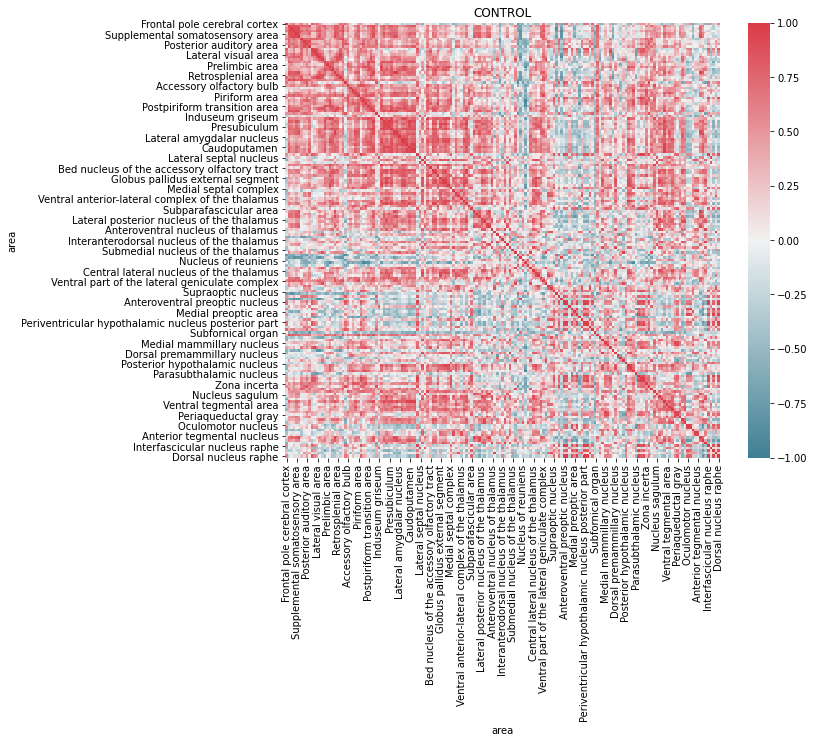

In [33]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

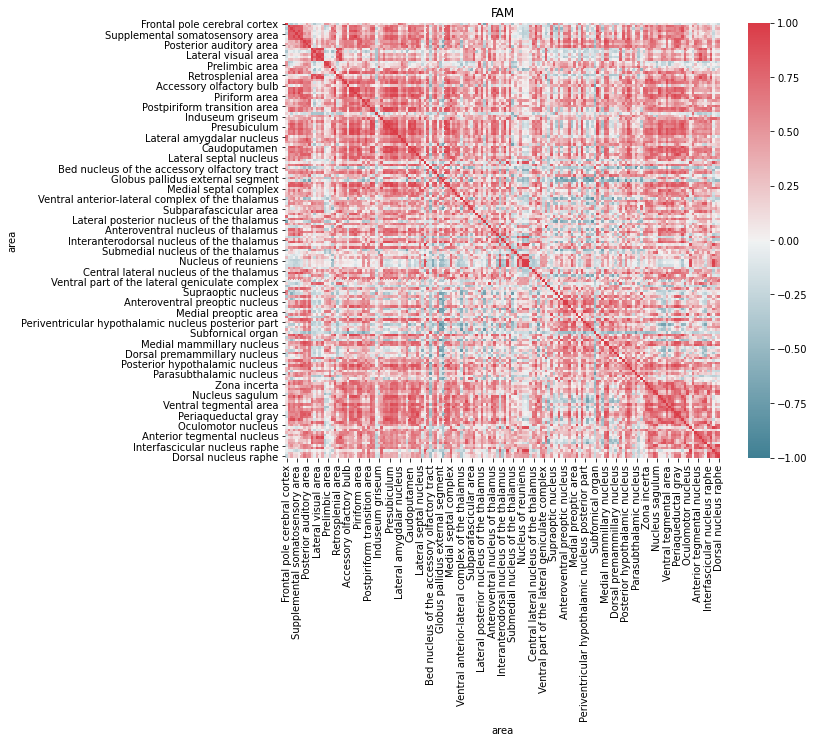

In [34]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

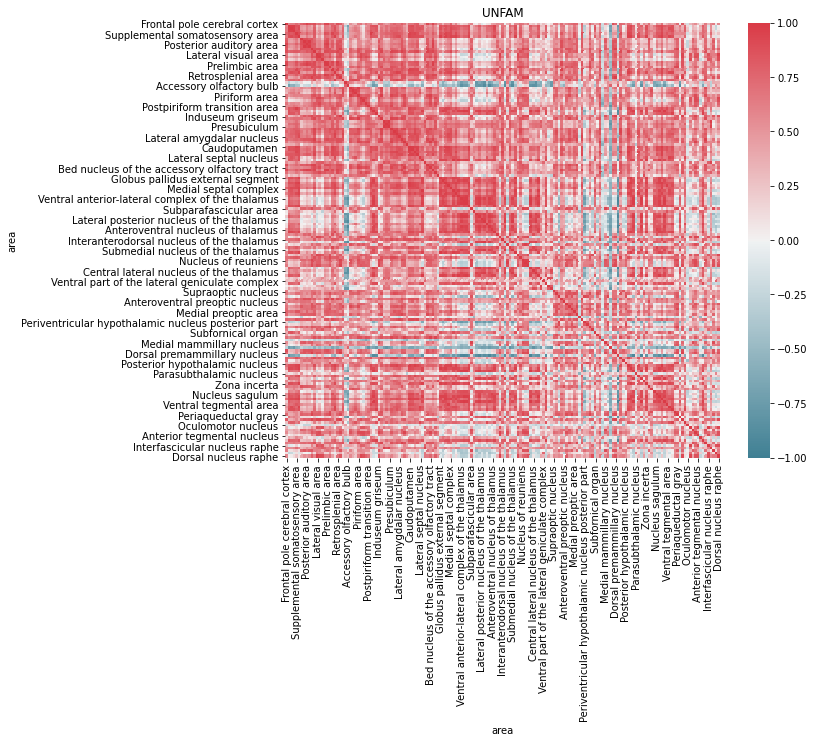

In [35]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')